##  BESO方法与实例
------------------------------

### 1. 简介

BESO方法是从进化结构优化[(ESO)方法](http://www.sciencedirect.com/science/article/pii/004579499390035C)开发的。 原始ESO是基于去除低应力材料的启发式方法。 通过多年的发展，目前形式的[BESO](https://link.springer.com/article/10.1007/s00466-008-0312-0)已经成为基于梯度的数学优化方法与收敛和网格独立算法。 BESO的最近的应用已经解决了一系列宏观结构优化问题，包括柔度最小化(最大化刚度)，频率最大化，位移约束以及反均匀化问题，如材料模量(moduli )最大化 和并发设计。

BESO方法经常解决的是受到体积约束的柔度最小化问题，这个问题的数学描述如下


$$ \underset{\mathbf{X}} { \arg\min} { \space C(\mathbf{X}}) \\ s.t.
\begin{cases}
C(\mathbf{X}) = \mathbf{F}^T\mathbf{U} = \mathbf{U}^T\mathbf{K}\mathbf{U} \\
\mathbf{X} = \{\mathcal{x_e}\}, \mathcal{x_e}=1 \space or \space \mathcal{x_{min}} \space  \forall e=1, \dots, N  \\
\mathbf{F} = \mathbf{KU}\\
V(\mathbf{X})=\sum_{\mathbf{X}} \mathcal{x_e} \mathcal{v_e}=\mathcal{V}^*
\end{cases}
$$ 



上式中：
$C()$：表达变形能，是问题的目标函数;

X：表达单元密度的一个矢量，当每个单元密度都0或1时，这成为一个离散问题。;

$x_e$表达第e个设计变量的可选值（1为实体，可以用0或很小的数，如0.01表达空腔）;

e：表示索引可能有些不太适应;

$N$：元素的总数; 

$F$，$U$：分别表达全局力矢量和位移矢量; 

$K$:全局刚度矩阵; 

$V$:结构的总体积，其中$v_e$是元素体积; 

$\mathcal{V}^*$:表示要求的体积约束值。

从上式中可以看到，柔度最小化是使模型的变形能最小，同时兼顾体积约束的要求，这就变成一个求材料空间分布的问题。




###  2. 系统流程

* 读取Mesh模型 & 演化规则
* 体素化
* 生成演化环境
* 演化：分析->感知->更新
* 后处理
------------------------------


#### 2.1 输入


拓扑优化方法的输入是一个具有固定外形的实体，并根据实际需求设定外部载荷和约束。在实际实现中，输入可为具有复杂外形的结构，因此这里涉及到GUI、体素化等复杂操作。有时为达到高性能的计算，需要GPU或多核加速。

#### 2.2 评价指标

作为基于梯度的方法(或许本质是基于梯度的方法)，设计变量更新是基于通过单元灵敏度$\alpha_e$(这里以e为索引，总是不直观), $\alpha_e$是目标函数$C$的导数。
$\alpha_e = \frac{\partial(\mathcal{C})}{\partial(\mathcal{x}_e)}$

这里根据SIMP的材料模型来计算这个导数[Huang & Xie 2009](http://t.cn/RarnNu1)，得到：

$\alpha_e = -p\mathcal{x}_e^{p-1} \mathbf{u}_e^T\mathbf{k}_0\mathbf{u}_e=-\frac{p}{\mathcal{x}_e}\mathcal{x}_e^{p} \mathbf{u}_e^T\mathbf{k }_0\mathbf{u}_e=-\frac{p}{\mathcal{x}_e} \mathbf{u}_e^T\mathbf{k }_0 \mathcal{x}_e^{p}\mathbf{u}_e$

可变量为$-p\mathcal{x}_e^{p-1}$,因为在单相材料的优化问题中，SIMP使用了差值方法使材料在数学上保持近似连续分布，此时杨氏（弹性）模量$K(x_i)= K_{solid}x_i^p$，$p$为惩罚因子，可以保证$0 < K(x_i) < K_{solid}$。

$\mathbf{u}_e$: 单元的位移向量

$\mathbf{k}_0$: 单元的刚度矩阵

$\mathcal{x}_e^{p} \mathbf{u}_e^T\mathbf{k}_0\mathbf{u}_e$：应变能，可直接从FEA中获得。

实际算法中使用单元灵敏度$\alpha_e$是一个局部邻域的加权平均值
$\hat \alpha_e=\frac{\sum_j{w{(r_{ej})\alpha_j}}} {\sum_j w(r_{ej} )} = \sum_j{\frac{w(r_{ej})}{\sum_j w(r_{ej})}\alpha}  = \sum_j \eta_j \alpha_j$
$w(r_{ej}) = max(0, r_{min}-r_{ej})$

其中,$r_{ej}=distant(element_e, element_j)$
w是权重函数; 
$r_{min}$是过滤器半径。
权重因子$\eta_j$与灵敏度值无关，可以事先计算。所以在这个Python实现中可只计算一次，并保存固定权重因子$\eta_j$，

In [23]:
# function preFlt
# todo 添加平滑示例
def preFlt(Rmin,Elmts,Nds,Fm): 
    # Calculate element centre coordinates
    elm, c0 = np.zeros(len(Elmts)), np.zeros((len(Elmts),3))
    for i in range(len(elm)):
        elm[i] = Elmts[i].label
        nds = Elmts[i].connectivity
        for nd in nds: c0[i] = np.add(c0[i],np.divide(Nds[nd].coordinates,len(nds)))
        
    print('Init')
    # Weighting factors
    for i in range(len(elm)):
        Fm[elm[i]] = [[],[]]
        for j in range(len(elm)):
            dis = np.square(np.sum(np.power(np.subtract(c0[i],c0[j]),2)))
            if dis<Rmin: 
                Fm[elm[i]][0].append(elm[j])
                Fm[elm[i]][1].append(Rmin - dis)
        Fm[elm[i]][1] = np.divide(Fm[elm[i]][1],np.sum(Fm[elm[i]][1]))

#### 2.3 设计迭代

设计迭代可以看做根据评价指标，重新分配空间材料（密度）的过程。

为了使解决方案能够收敛，建议使用BESO等离散方法的历史信息，进一步平均灵敏度[Xie et al. 2009]。 这通过简单地平均当前迭代的灵敏度与前一次迭代的灵敏度来实现,例如：

$\hat \alpha_e = \frac{\hat \alpha^k_e + \hat \alpha^{k-1}_e}{2}$

在迭代过程中，一个单元如果灵敏度很小，表示体积变化对全局刚度变化不敏感，可以安全去除。反之则应该增加密度。

SIMP采用类似的连续更新机制，每次针对每一个单元增加或减小$\Delta \rho$

从经验上来看，对于集中力载荷，SIMP的更新机制可以很好的使迭代过程收敛[Wu 2016，A system for High...]，但对于分布力，则会导致不稳定的孔隙设计。原因是分布力使结构内部各处的灵敏度趋向一致，这时BESO方法离散的更新机制成为一个更好的选择。

BESO也通过迭代减少或增加结构体积，每次变化的量小于进化比（ert），即：
$V^{k+1} = V^k(1 \pm ert)$

其密度更新的机制是：如果有一个灵敏度权值，将大于这个灵敏度权值的单元保留，小于权值的单元去除（密度设为一个极小值），使体积刚好满足预定义的要求。这个权值的求法见下边的算法。

对于最小化问题，固体密度$x_e=1$的灵敏度总是小于空白部分的灵敏度（这里我们不能直接设置空白结构的密度为0，而是等于一个很小的值，如$x_e = 0.01$）。在迭代过程中，$\alpha_e$小于阈值th，元素$v_e$被设置为实体，$\alpha_e$大于阈值th，$v_e$被设置为空腔。确定阈值th的算法被定义为

```
input: ae, xe, target_volume
output: threshold th
lo = min(ae), hi = max(ae)
while(hi - ho) / hi > 0.00001
  th = (lo + hi ) / 2
  for i = 1 to N
    if ae[i] > th: xe[i] = 1
    else ae[i] = 0.001
  if(sum(xe) - tv > 0): 
     lo = th
  else:
     hi = th
end while 
  
```
这个方法逐步提高阈值，直到把足够多的材料去除掉，如果不是以轻量化为目标，则可能采用不同的更新策略或约束条件。


###  2. 演化实例
以fandaL的[beso](https://github.com/fandaL/beso)实现为例，使用[CalculiX](http://www.calculix.de/)作为FEM求解器。


#### 2.1 初始化
 - 读配置文件,所有配置放在./beso/beso_conf.py,可独立运行；
 - 配置path_calculix（beso_conf.py）
 - 相关代码段在./beso/目录中；
 - 导入代码段后，将./beso目录从路径中删除。
 
 实例中的元素集合

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import os
import sys
import subprocess
import time
# import local code
beso_path = os.getcwd() + '/beso'
sys.path.append(beso_path)
import beso_lib
import beso_filters
import beso_separate


# initialization of variables
domain_optimized = {}
domain_density = {}
domain_thickness = {}
domain_offset = {}  # TODO read offset from .inp file
domain_FI = {}
domain_material = {}
path = None
path_calculix = None
file_name = None
mass_goal_ratio = None
continue_from = None
filter_list = None
r_min = None
filter_on_sensitivity = None
cpu_cores = None
FI_violated_tolerance = None
decay_coefficient = None
shells_as_composite = None
reference_points = None
reference_value = None
mass_addition_ratio = None
mass_removal_ratio = None
ratio_type = None
sensitivity_averaging = None
iterations_limit = None
tolerance = None
save_iteration_results = None
save_iteration_format = None

# read configuration file to fill variables listed above
exec(open("./beso/beso_conf.py").read())
domains_from_config = domain_optimized.keys()
criteria = []
for dn in domain_FI:  # extracting each type of criteria    
    for state in range(len(domain_FI[dn])):          
        for dn_crit in domain_FI[dn][state]:
            print(dn_crit)
            if dn_crit not in criteria:
                criteria.append(dn_crit)

number_of_states = 0  # find number of states possible in elm_states
for dn in domains_from_config:
    number_of_states = max(number_of_states, len(domain_density[dn]))



('stress_von_Mises', 450000000.0)
('stress_von_Mises', 450.0)


读取分析后文件时，具体criteria可选择：

* stress_von_Mises 

$ \sigma_{VM} = \sqrt{\frac{(\sigma_{xx} - \sigma_{yy})^2 + (\sigma_{yy} - \sigma_{zz})^2 + (\sigma_{zz} - \sigma_{xx})^2 + 6(\tau_{xy}^2 + \tau_{yz}^2 + \tau_{zx}^2)}{2}}$

* user_def

否则使用自定义eval(criteria[i][1])


In [5]:
print(criteria)

[('stress_von_Mises', 450000000.0), ('stress_von_Mises', 450.0)]


In [6]:
if iterations_limit == 0:  # automatic setting
    if ratio_type == "absolute":
        iterations_limit = int((1 - mass_goal_ratio) / abs(mass_removal_ratio - mass_addition_ratio) + 25)
    elif ratio_type == "relative":
        m = 1
        it = 0
        while m > mass_goal_ratio:
            m -= m * abs(mass_removal_ratio - mass_addition_ratio)
            it += 1
        iterations_limit = it + 25
    print("iterations_limit set to %s" % iterations_limit)

iterations_limit set to 105


mass_addition_ratio = 0.01 当前设置的每个循环添加质量百分比

mass_removal_ratio = 0.03  当前设置的每个循环杀出质量百分比

当iterations_limit = 0时，默认的循环次数可设置为：

* ratio_type == 'relative'  每次迭代改变的质量按照**当前质量**的百分比计算

iterations_limit = $ \frac{1 - mass\_goal\_ratio}{mass\_removal\_ratio - mass\_addition\_ratio} + 25$

* ratio_type == "absolute"  每次迭代改变的质量按照**最大质量**的百分比计算

按照每次迭代减少的质量计算达到目标质量的次数



In [7]:
# set an environmental variable driving number of cpu cores to be used by CalculiX
if cpu_cores == 0:  # use all processor cores
    cpu_cores = multiprocessing.cpu_count()
os.putenv('OMP_NUM_THREADS', str(cpu_cores))

#### reset iterations_limit only for demosration
iterations_limit = 80

# print log file with settings
msg = "\n"
msg += "---------------------------------------------------\n"
msg += ("file_name = %s\n" % file_name)
msg += ("Start at    " + time.ctime() + "\n\n")
for dn in domain_optimized:
    msg += ("elset_name              = %s\n" % dn)
    msg += ("domain_optimized        = %s\n" % domain_optimized[dn])
    msg += ("domain_density          = %s\n" % domain_density[dn])
    msg += ("domain_thickness        = %s\n" % domain_thickness[dn])
    msg += ("domain_FI               = %s\n" % domain_FI[dn])
    msg += ("domain_material         = %s\n" % domain_material[dn])
    msg += "\n"
msg += ("mass_goal_ratio         = %s\n" % mass_goal_ratio)
msg += ("filter_list             = %s\n" % filter_list)
msg += ("r_min                   = %s\n" % r_min)
msg += ("filter_on_sensitivity   = %s\n" % filter_on_sensitivity)
msg += ("cpu_cores               = %s\n" % cpu_cores)
msg += ("FI_violated_tolerance   = %s\n" % FI_violated_tolerance)
msg += ("decay_coefficient       = %s\n" % decay_coefficient)
msg += ("shells_as_composite     = %s\n" % shells_as_composite)
msg += ("reference_points        = %s\n" % reference_points)
msg += ("reference_value         = %s\n" % reference_value)
msg += ("mass_addition_ratio     = %s\n" % mass_addition_ratio)
msg += ("mass_removal_ratio      = %s\n" % mass_removal_ratio)
msg += ("ratio_type              = %s\n" % ratio_type)
msg += ("sensitivity_averaging   = %s\n" % sensitivity_averaging)
msg += ("iterations_limit        = %s\n" % iterations_limit)
msg += ("tolerance               = %s\n" % tolerance)
msg += ("save_iteration_results  = %s\n" % save_iteration_results)
msg += ("save_iteration_format   = %s\n" % save_iteration_format)
msg += "\n"

print(msg)


sys.path.remove(beso_path)


---------------------------------------------------
file_name = r:/testData/Plane_Mesh.inp
Start at    Wed Dec 13 14:07:01 2017

elset_name              = SolidMaterialElementGeometry2D
domain_optimized        = True
domain_density          = [1e-06, 1]
domain_thickness        = [1.0, 1.0]
domain_FI               = [[('stress_von_Mises', 450000000.0)], [('stress_von_Mises', 450.0)]]
domain_material         = ['*ELASTIC \n210000e-6,  0.3', '*ELASTIC \n210000,  0.3']

mass_goal_ratio         = 0.2
filter_list             = [['simple', 2]]
r_min                   = 2.0
filter_on_sensitivity   = 0
cpu_cores               = 8
FI_violated_tolerance   = 1
decay_coefficient       = -0.2
shells_as_composite     = False
reference_points        = integration points
reference_value         = max
mass_addition_ratio     = 0.01
mass_removal_ratio      = 0.03
ratio_type              = relative
sensitivity_averaging   = False
iterations_limit        = 80
tolerance               = 0.001
save_iteration

 #### 2.2 读取输入
 
  - 读inp文件
 在beso_conf.py中设置，例如
 ```
 file_name = "./testData/Plane_Mesh.inp" 
 ```
  inp文件是Abquas的原始输入格式（输出为ODB），读入单元集合与约束。inp中的注释以\**开头，\*则表示关键的内容段。
 BESO的第一步是初始化FEM模型
 [nodes] = [[x,y,z],[x,y,z]...]
 
 ```
 *Node, NSET=Nall
 1, 0, 0, 0
 2, 0, 30, 0
 ```
 
 [Elements] = 
 
 ```
 *Element, TYPE=S4, ELSET=Eall
 261, 347, 435, 632, 343
 262, 632, 836, 868, 739
 263, 739, 868, 887, 631
 ```
 这里number_of_nodes = 4  shells_as_composite = false
 四面体体素信息存储在对象Elements.quad4中，初始化elm_states[idx] = 1为当前节点的密度索引。
 

In [8]:
# mesh and domains importing
[nodes, Elements, domains, opt_domains, en_all, plane_strain, plane_stress, axisymmetry] = beso_lib.import_inp(
    file_name, domains_from_config, domain_optimized, shells_as_composite)
domain_shells = {}
domain_volumes = {}
for dn in domains_from_config:  # distinguishing shell elements and volume elements
    domain_shells[dn] = set(domains[dn]).intersection(list(Elements.tria3.keys()) + list(Elements.tria6.keys()) +
                                                      list(Elements.quad4.keys()) + list(Elements.quad8.keys()))
    domain_volumes[dn] = set(domains[dn]).intersection(list(Elements.tetra4.keys()) + list(Elements.tetra10.keys()) +
                                                       list(Elements.hexa8.keys()) + list(Elements.hexa20.keys()) +
                                                       list(Elements.penta6.keys()) + list(Elements.penta15.keys()))

elm_states = {}  # initial element state
if continue_from[-4:] == ".frd":
    elm_states = beso_lib.import_frd_state(continue_from, elm_states, number_of_states, file_name)
elif continue_from[-4:] == ".inp":
    elm_states = beso_lib.import_inp_state(continue_from, elm_states, number_of_states, file_name)
else:
    for dn in domains_from_config:
        for en in domains[dn]:
            elm_states[en] = len(domain_density[dn]) - 1  # set to highest state
    #print(dn)



domains: 1
nodes  : 3131
TRIA3  : 0
TRIA6  : 0
QUAD4  : 3000
QUAD8  : 0
TETRA4 : 0
TETRA10: 0
HEXA8  : 0
HEXA20 : 0
PENTA6 : 0
PENTA15: 0



In [13]:
print(opt_domains)

[261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460,

  - 下一步要计算每个单元的体积、重心
  
    

In [238]:
# computing volume or area, and centre of gravity of each element
[cg, cg_min, cg_max, volume_elm, area_elm] = beso_lib.elm_volume_cg(file_name, nodes, Elements)
mass = [0.0]
mass_full = 0  # sum from 0th list position TODO make it independent on starting elm_states?

for dn in domains_from_config:
    if domain_optimized[dn] is True:
        for en in domain_shells[dn]:
            mass[0] += domain_density[dn][elm_states[en]] * area_elm[en] * domain_thickness[dn][elm_states[en]]
            mass_full += domain_density[dn][len(domain_density[dn]) - 1] * area_elm[en] * domain_thickness[dn][
                                                                                            len(domain_density[dn]) - 1]
        for en in domain_volumes[dn]:
            mass[0] += domain_density[dn][elm_states[en]] * volume_elm[en]
            mass_full += domain_density[dn][len(domain_density[dn]) - 1] * volume_elm[en]
print("initial optimization domains mass {}" .format(mass[0]))

# preparing parameters for filtering sensitivity numbers
weight_factor2 = {}
near_elm = {}
for ft in filter_list:
    if ft[0] and ft[1]:
        f_range = ft[1]
        if len(ft) == 2:
            domains_to_filter = list(opt_domains)
        else:
            domains_to_filter = []
            for dn in ft[2:]:
                domains_to_filter += domains[dn]
        if ft[0] == "simple":
            [weight_factor2, near_elm] = beso_filters.prepare2s(cg, cg_min, cg_max, f_range, domains_to_filter,
                                                                weight_factor2, near_elm)
        elif ft[0].split()[0] in ["erode", "dilate", "open", "close", "open-close", "close-open", "combine"]:
            near_elm = beso_filters.prepare_morphology(cg, cg_min, cg_max, f_range, domains_to_filter, near_elm)

if filter_on_sensitivity == "over nodes":
    [weight_factor_node, M, weight_factor_distance, near_nodes] = beso_filters.prepare1s(nodes, Elements, cg, r_min,
                                                                                         opt_domains)
elif filter_on_sensitivity == "over points":
    [weight_factor3, near_elm3, near_points] = beso_filters.prepare3(file_name, cg, cg_min, r_min, opt_domains)

# separating elements for reading nodal input
if reference_points == "nodes":
    beso_separate.separating(file_name, nodes)

# writing log table header
msg = "\n"
msg += "domain order: \n"
dorder = 0
for dn in domains_from_config:
    msg += str(dorder) + ") " + dn + "\n"
    dorder += 1
msg += "\niteration              mass FI_violated_0)"
for dno in range(len(domains_from_config) - 1):
    msg += (" " + str(dno + 1)).rjust(4, " ") + ")"
if len(domains_from_config) > 1:
    msg += " all)"
msg += "          FI_mean    _without_state0         FI_max 0)"
for dno in range(len(domains_from_config) - 1):
    msg += str(dno + 1).rjust(17, " ") + ")"
if len(domains_from_config) > 1:
    msg += "all".rjust(17, " ") + ")"
msg += "\n"
print(msg)


initial optimization domains mass 2999.999999999999

domain order: 
0) SolidMaterialElementGeometry2D

iteration              mass FI_violated_0)          FI_mean    _without_state0         FI_max 0)



我们首先尝试可视化输入结构。
    
  * 函数dispVolume的参数分别为element_centers：元素重心数组，元素状态（密度）数组，figure titile
  * 以二维四面体重心表达一个体素，绘制所有二维体素。
  * 绘制被删除的体素
    

In [243]:
def dispVolume(element_centers, ele_state, strTitle):
    plt.figure(figsize=(7,5))
    plt.figure(0)
    
    _N = len(element_centers)
    X = np.zeros([_N,2])   # elements
    Xr = np.array([])      # removed element
    S = np.zeros(_N)       # element state
    
    
    _idx = 0
    for i in element_centers.keys():
        X[_idx] = element_centers[i][0:2]
        S[_idx] = ele_state[i]
        if S[_idx] < 0.1: 
            Xr = np.append (Xr , X[_idx])
            
        _idx += 1
    Xr = Xr.reshape( (len(Xr) // 2, 2) )  
     
    
    plt.scatter(X[:,0], X[:, 1], c='b', marker ='x')
    plt.scatter(Xr[:,0], Xr[:, 1], c='w', marker ='o')
    #plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(strTitle)
    plt.show()
    print(len(Xr)) 

#dispVolume(cg,elm_states, "test plot")   
#print(len(cg))
#print(len(Elements.quad4))


 #### 2.3 优化迭代
 
 - 为Calculix创建一个新的输入文件，如 path/file000.inp，我把它放在了内存盘上，以提高效率。
 - 迭代
  * 为CalculiX建立inp文件
  * ccx *.inp
  * 从.dat或.frd格式中取得

e:/temp/file000.dat
domain ordered 
FI_max and number of violated elements
 0.522617299519    0
FI_mean                = 0.044862498135827454
FI_mean_without_state0 = 0.044862498135827454

----------- new iteration number 1 ----------
mass = 2909.0000909999885


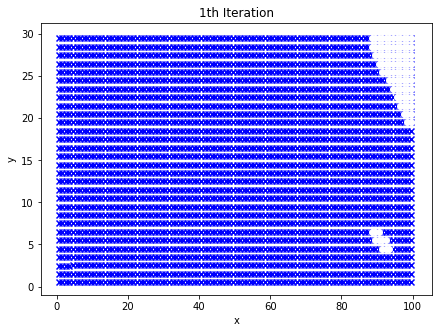

91
e:/temp/file001.dat
domain ordered 
FI_max and number of violated elements
 0.522610217335    0
FI_mean                = 0.046226848652342716
FI_mean_without_state0 = 0.04622685009842135
2 files with resulting meshes have been created

----------- new iteration number 2 ----------
mass = 2851.000148999994


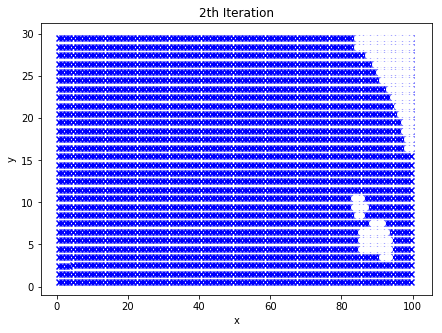

149
e:/temp/file002.dat
domain ordered 
FI_max and number of violated elements
  6.42273390901   13
FI_mean                = 0.07187348507161379
FI_mean_without_state0 = 0.07187348882789191

----------- new iteration number 3 ----------
mass = 2851.000149000003


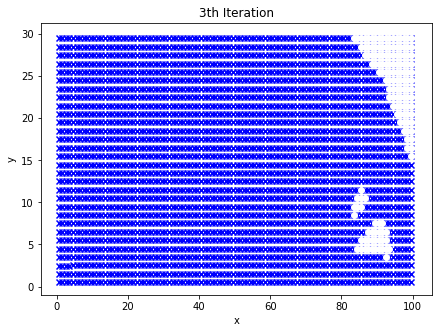

149
e:/temp/file003.dat
domain ordered 
FI_max and number of violated elements
 0.525037863515    0
FI_mean                = 0.047317533651835
FI_mean_without_state0 = 0.047317536124761236

----------- new iteration number 4 ----------
mass = 2804.0001959999972


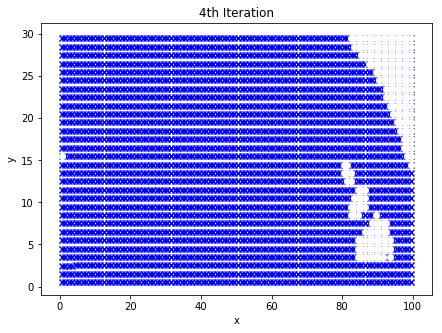

196
e:/temp/file004.dat
domain ordered 
FI_max and number of violated elements
 0.522613660981    0
FI_mean                = 0.04801584659492908
FI_mean_without_state0 = 0.048015849951243576

----------- new iteration number 5 ----------
mass = 2766.0002339999983


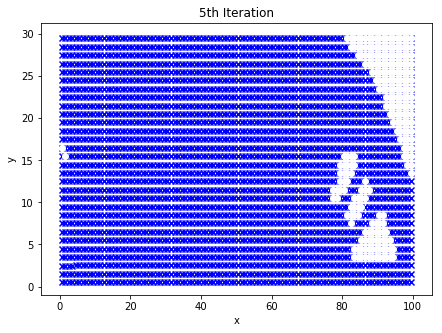

234
e:/temp/file005.dat
domain ordered 
FI_max and number of violated elements
 0.522605493761    0
FI_mean                = 0.048687149410170195
FI_mean_without_state0 = 0.04868715352903964
maximum relative difference in FI_mean for the last 5 iterations = 0.47623111934748485

----------- new iteration number 6 ----------
mass = 2736.0002639999984


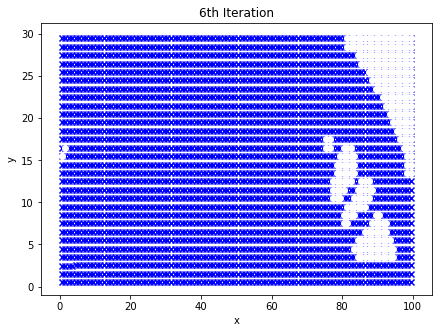

264
e:/temp/file006.dat
domain ordered 
FI_max and number of violated elements
 0.522596046133    0
FI_mean                = 0.04928050450022201
FI_mean_without_state0 = 0.04928050925535839
maximum relative difference in FI_mean for the last 5 iterations = 0.4584567629840313
2 files with resulting meshes have been created

----------- new iteration number 7 ----------
mass = 2712.000287999997


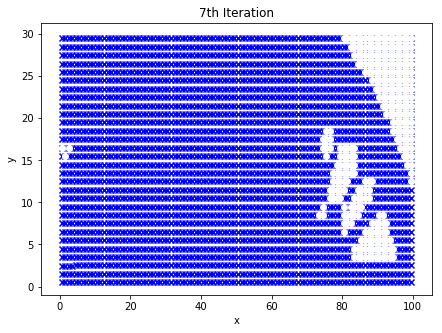

288
e:/temp/file007.dat
domain ordered 
FI_max and number of violated elements
 0.522596536377    0
FI_mean                = 0.04976406526248921
FI_mean_without_state0 = 0.049764070547168665
maximum relative difference in FI_mean for the last 5 iterations = 0.4442848407280354

----------- new iteration number 8 ----------
mass = 2692.0003079999965


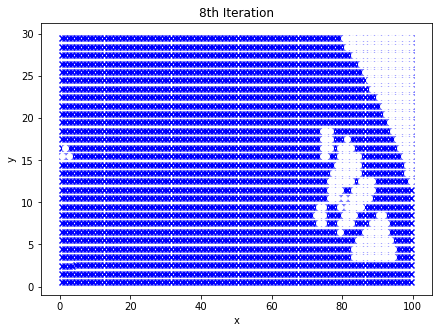

308
e:/temp/file008.dat
domain ordered 
FI_max and number of violated elements
 0.522591009779    0
FI_mean                = 0.050204299883491704
FI_mean_without_state0 = 0.05020430562752003
maximum relative difference in FI_mean for the last 5 iterations = 0.057500378221705666

----------- new iteration number 9 ----------
mass = 2676.0003239999974


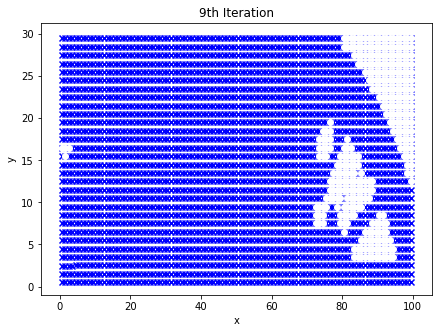

324
e:/temp/file009.dat
domain ordered 
FI_max and number of violated elements
  3.15306526774   16
FI_mean                = 0.07551018396611302
FI_mean_without_state0 = 0.07551019310860162
maximum relative difference in FI_mean for the last 5 iterations = 0.36411429461650724

----------- new iteration number 10 ----------
mass = 2676.0003239999974


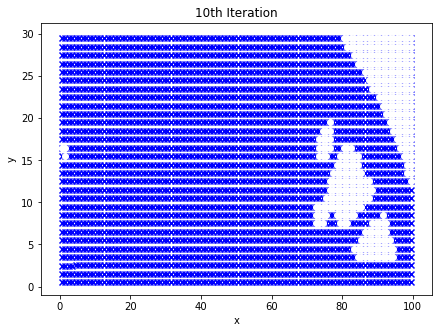

324
e:/temp/file010.dat
domain ordered 
FI_max and number of violated elements
 0.522626906977    0
FI_mean                = 0.05054863269321275
FI_mean_without_state0 = 0.05054863881345075
maximum relative difference in FI_mean for the last 5 iterations = 0.49381259082507095

----------- new iteration number 11 ----------
mass = 2665.0003349999956


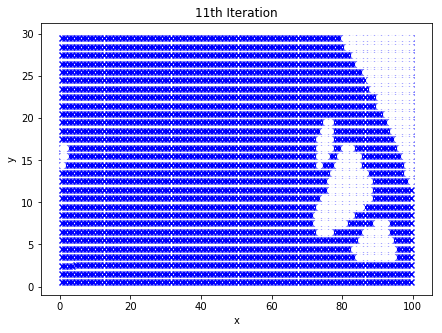

335
e:/temp/file011.dat
domain ordered 
FI_max and number of violated elements
 0.522612002342    0
FI_mean                = 0.05069152875781015
FI_mean_without_state0 = 0.05069153512991594
maximum relative difference in FI_mean for the last 5 iterations = 0.48960163199810797
2 files with resulting meshes have been created

----------- new iteration number 12 ----------
mass = 2656.000343999998


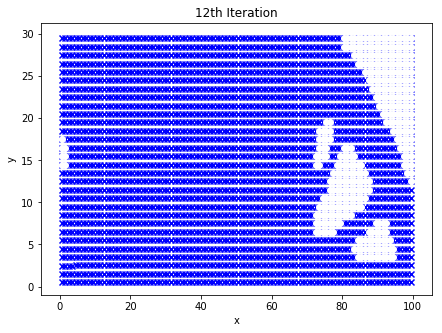

344
e:/temp/file012.dat
domain ordered 
FI_max and number of violated elements
 0.522616694268    0
FI_mean                = 0.050861574467863976
FI_mean_without_state0 = 0.050861581055357034
maximum relative difference in FI_mean for the last 5 iterations = 0.48462144076611013

----------- new iteration number 13 ----------
mass = 2649.000350999999


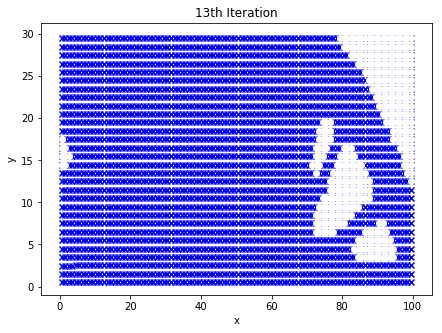

351
e:/temp/file013.dat
domain ordered 
FI_max and number of violated elements
 0.522619998134    0
FI_mean                = 0.05099134436990519
FI_mean_without_state0 = 0.050991351126402684
maximum relative difference in FI_mean for the last 5 iterations = 0.48084316856487336

----------- new iteration number 14 ----------
mass = 2643.000356999998


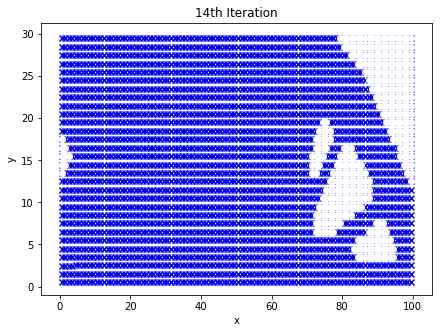

357
e:/temp/file014.dat
domain ordered 
FI_max and number of violated elements
 0.522620049336    0
FI_mean                = 0.05107962207463515
FI_mean_without_state0 = 0.05107962897415275
maximum relative difference in FI_mean for the last 5 iterations = 0.47828392026434874

----------- new iteration number 15 ----------
mass = 2638.000361999995


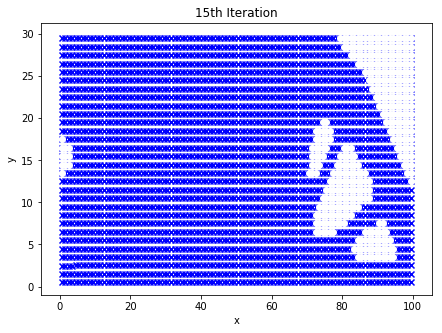

362
e:/temp/file015.dat
domain ordered 
FI_max and number of violated elements
 0.522621664455    0
FI_mean                = 0.05118571908434766
FI_mean_without_state0 = 0.051185726108316676
maximum relative difference in FI_mean for the last 5 iterations = 0.012446565224278134

----------- new iteration number 16 ----------
mass = 2634.000365999962


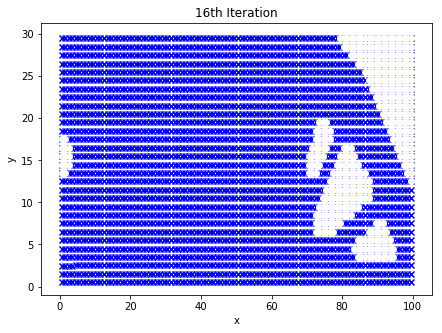

366
e:/temp/file016.dat
domain ordered 
FI_max and number of violated elements
 0.522620615535    0
FI_mean                = 0.051235253195506154
FI_mean_without_state0 = 0.05123526031475544
maximum relative difference in FI_mean for the last 5 iterations = 0.010612310934060084
2 files with resulting meshes have been created

----------- new iteration number 17 ----------
mass = 2631.0003689999617


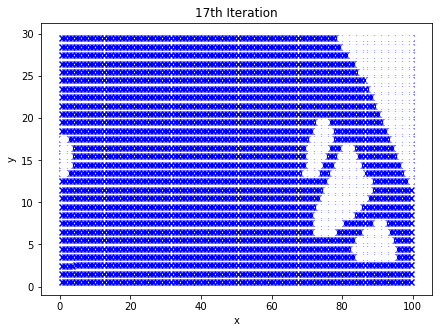

369
e:/temp/file017.dat
domain ordered 
FI_max and number of violated elements
 0.522628335692    0
FI_mean                = 0.051298397097768136
FI_mean_without_state0 = 0.05129840429241217
maximum relative difference in FI_mean for the last 5 iterations = 0.008515327078770752

----------- new iteration number 18 ----------
mass = 2629.000370999962


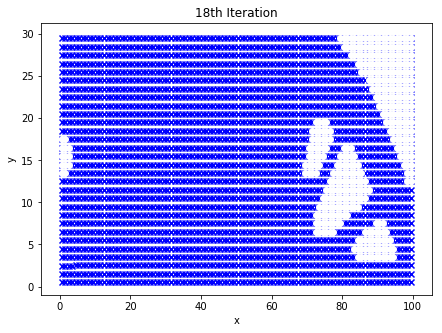

371
e:/temp/file018.dat
domain ordered 
FI_max and number of violated elements
 0.522629308509    0
FI_mean                = 0.051332898333363276
FI_mean_without_state0 = 0.05133290557737439
maximum relative difference in FI_mean for the last 5 iterations = 0.006653705022459176

----------- new iteration number 19 ----------
mass = 2627.0003729999617


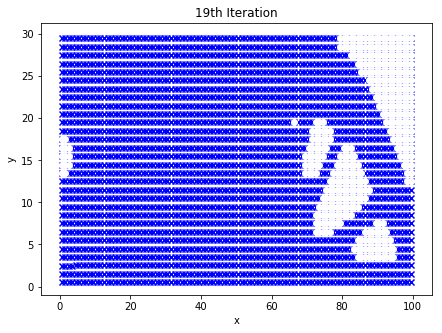

373
e:/temp/file019.dat
domain ordered 
FI_max and number of violated elements
 0.522632569235    0
FI_mean                = 0.05137549906493068
FI_mean_without_state0 = 0.05137550635958659
maximum relative difference in FI_mean for the last 5 iterations = 0.005759106883255458

----------- new iteration number 20 ----------
mass = 2625.0003749999614


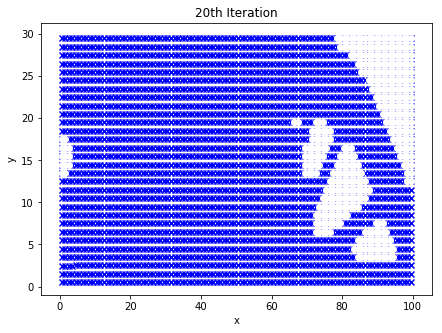

375
e:/temp/file020.dat
domain ordered 
FI_max and number of violated elements
 0.522628935212    0
FI_mean                = 0.05141802458531318
FI_mean_without_state0 = 0.05141803193074524
maximum relative difference in FI_mean for the last 5 iterations = 0.004517977943319819

----------- new iteration number 21 ----------
mass = 2623.000376999961


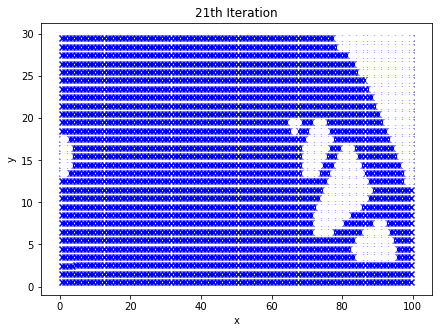

377
e:/temp/file021.dat
domain ordered 
FI_max and number of violated elements
  11.6375299464   96
FI_mean                = 0.20027269463164693
FI_mean_without_state0 = 0.20027272341655183
maximum relative difference in FI_mean for the last 5 iterations = 0.7441725478865655
2 files with resulting meshes have been created

----------- new iteration number 22 ----------
mass = 2623.0003769999616


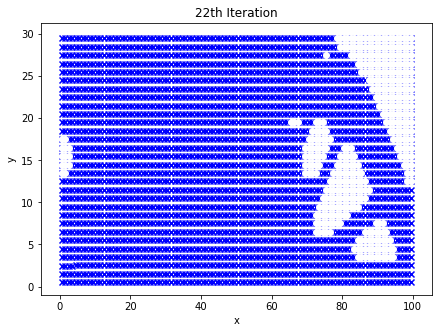

377
e:/temp/file022.dat
domain ordered 
FI_max and number of violated elements
 0.522629044371    0
FI_mean                = 0.051479281257414675
FI_mean_without_state0 = 0.051479288656457366
maximum relative difference in FI_mean for the last 5 iterations = 2.8903552990612353

----------- new iteration number 23 ----------
mass = 2622.0003779999615


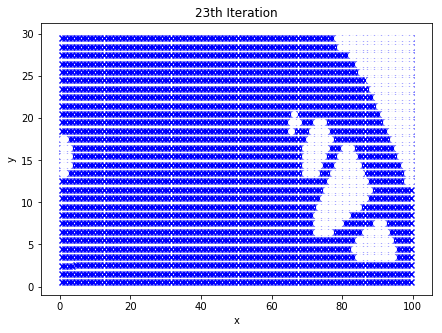

378
e:/temp/file023.dat
domain ordered 
FI_max and number of violated elements
 0.522629329632    0
FI_mean                = 0.05147662124236025
FI_mean_without_state0 = 0.05147662866347496
maximum relative difference in FI_mean for the last 5 iterations = 2.8905563301975614

----------- new iteration number 24 ----------
mass = 2621.0003789999614


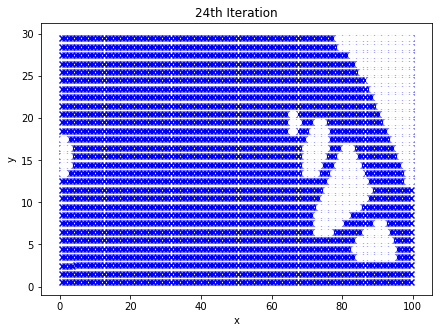

379
e:/temp/file024.dat
domain ordered 
FI_max and number of violated elements
 0.522629529676    0
FI_mean                = 0.05149992978230493
FI_mean_without_state0 = 0.05149993722926156
maximum relative difference in FI_mean for the last 5 iterations = 2.8887954892019954

----------- new iteration number 25 ----------
mass = 2621.0003789999614


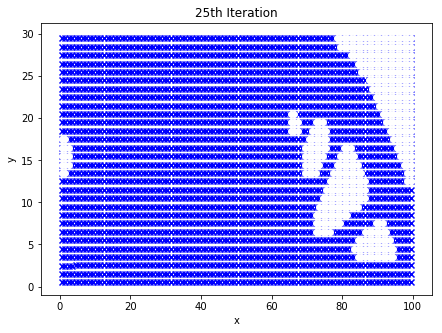

379
e:/temp/file025.dat
domain ordered 
FI_max and number of violated elements
 0.522629411122    0
FI_mean                = 0.0515074114394203
FI_mean_without_state0 = 0.051507418887458786
maximum relative difference in FI_mean for the last 5 iterations = 2.888230626134159

----------- new iteration number 26 ----------
mass = 2621.0003789999614


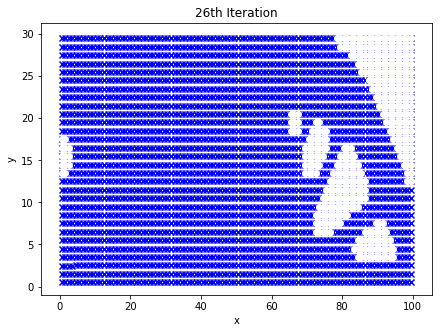

379
e:/temp/file026.dat
domain ordered 
FI_max and number of violated elements
 0.522629718962    0
FI_mean                = 0.05150681501026164
FI_mean_without_state0 = 0.051506822458213884
maximum relative difference in FI_mean for the last 5 iterations = 2.8882756503531977
2 files with resulting meshes have been created

----------- new iteration number 27 ----------
mass = 2621.000378999962


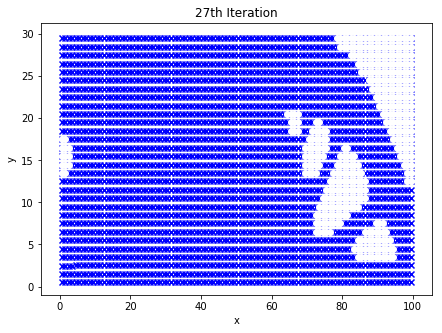

379
e:/temp/file027.dat
domain ordered 
FI_max and number of violated elements
 0.522630044858    0
FI_mean                = 0.05151030545909223
FI_mean_without_state0 = 0.0515103129075492
maximum relative difference in FI_mean for the last 5 iterations = 0.0006539316051761637

Finish at                          Wed Nov 22 20:05:16 2017
Total time                         108.54302549362183 s


total time: 108.54302549362183 s


In [241]:
# ITERATION CYCLE
start_time = time.time()
sensitivity_number = {}
sensitivity_number_old = {}
FI_max = []
FI_mean = []  # list of mean stress in every iteration
FI_mean_without_state0 = []  # mean stress without elements in state 0
FI_violated = []
i = 0
i_violated = 0
continue_iterations = True
check_tolerance = False
elm_states_before_last = {}
elm_states_last = elm_states

while True:
    # creating a new .inp file for CalculiX
    file_nameW = "e:/temp/file" + str(i).zfill(3)
    beso_lib.write_inp(file_name, file_nameW, elm_states, number_of_states, domains, domains_from_config,
                       domain_optimized, domain_thickness, domain_offset, domain_material, domain_volumes,
                       domain_shells, plane_strain, plane_stress, axisymmetry, save_iteration_results, i,
                       reference_points, shells_as_composite)
    # running CalculiX analysis
    subprocess.call(os.path.normpath(path_calculix) + " " + os.path.join(path, file_nameW), shell=True)

    # reading results and computing failure indeces
    if reference_points == "integration points":  # from .dat file
        FI_step = beso_lib.import_FI_int_pt(reference_value, file_nameW, domains, criteria, domain_FI, file_name,
                                            elm_states, domains_from_config)
    elif reference_points == "nodes":  # from .frd file
        FI_step = beso_lib.import_FI_node(reference_value, file_nameW, domains, criteria, domain_FI, file_name,
                                          elm_states)
    os.remove(file_nameW + ".inp")
    if not save_iteration_results or np.mod(float(i - 1), save_iteration_results) != 0:
        os.remove(file_nameW + ".dat")
        os.remove(file_nameW + ".frd")
    os.remove(file_nameW + ".sta")
    os.remove(file_nameW + ".cvg")
    FI_max.append({})
    for dn in domains_from_config:
        FI_max[i][dn] = 0
        for en in domains[dn]:
            for sn in range(len(FI_step)):
                try:
                    FI_step_en = list(filter(lambda a: a is not None, FI_step[sn][en]))  # drop None FI
                    FI_max[i][dn] = max(FI_max[i][dn], max(FI_step_en))
                except ValueError:
                    msg = "FI_max computing failed. Check if each domain contains at least one failure criterion."
                    beso_lib.write_to_log(file_name, "ERROR: " + msg + "\n")
                    raise Exception(msg)
                except KeyError:
                    msg = "Some result values are missing. Check available disk space."
                    beso_lib.write_to_log(file_name, "ERROR: " + msg + "\n")
                    raise Exception(msg)
    print("domain ordered \nFI_max and number of violated elements")

    # handling with more steps
    FI_step_max = {}  # maximal FI over all steps for each element in this iteration
    FI_violated.append([])
    dno = 0
    for dn in domains_from_config:
        FI_violated[i].append(0)
        for en in domains[dn]:
            FI_step_max[en] = 0
            for sn in range(len(FI_step)):
                FI_step_en = list(filter(lambda a: a is not None, FI_step[sn][en]))  # drop None FI
                FI_step_max[en] = max(FI_step_max[en], max(FI_step_en))
            sensitivity_number[en] = FI_step_max[en] / domain_density[dn][elm_states[en]]
            if FI_step_max[en] >= 1:
                FI_violated[i][dno] += 1
        print(str(FI_max[i][dn]).rjust(15) + " " + str(FI_violated[i][dno]).rjust(4))
        dno += 1

    # filtering sensitivity number
    for ft in filter_list:
        if ft[0] and ft[1]:
            if len(ft) == 2:
                domains_to_filter = list(opt_domains)
            else:
                domains_to_filter = []
                for dn in ft[2:]:
                    domains_to_filter += domains[dn]
            if ft[0] == "simple":
                sensitivity_number = beso_filters.run2(file_name, sensitivity_number, weight_factor2, near_elm,
                                                       domains_to_filter)
            elif ft[0].split()[0] in ["erode", "dilate", "open", "close", "open-close", "close-open", "combine"]:
                if ft[0].split()[1] == "sensitivity":
                    domains_en_in_state = [[]] * number_of_states
                    for en in domains_to_filter:
                        sn = elm_states[en]
                        domains_en_in_state[sn].append(en)
                    for sn in range(number_of_states):
                        if domains_en_in_state[sn]:
                            sensitivity_number = beso_filters.run_morphology(sensitivity_number, near_elm,
                                                                             domains_en_in_state[sn], ft[0].split()[0])
    if filter_on_sensitivity == "over nodes":
        sensitivity_number = beso_filters.run1(file_name, sensitivity_number, weight_factor_node, M,
                                               weight_factor_distance, near_nodes, nodes, opt_domains)
    elif filter_on_sensitivity == "over points":
        sensitivity_number = beso_filters.run3(sensitivity_number, weight_factor3, near_elm3, near_points)

    if sensitivity_averaging:
        for en in opt_domains:
            # averaging with the last iteration should stabilize iterations
            if i > 0:
                sensitivity_number[en] = (sensitivity_number[en] + sensitivity_number_old[en]) / 2.0
            sensitivity_number_old[en] = sensitivity_number[en]  # for averaging in the next step

    # computing mean stress from maximums of each element in all steps in the optimization domain
    FI_mean_sum = 0
    FI_mean_sum_without_state0 = 0
    mass_without_state0 = 0
    for dn in domain_optimized:
        if domain_optimized[dn] is True:
            for en in domain_shells[dn]:
                mass_elm = domain_density[dn][elm_states[en]] * area_elm[en] * domain_thickness[dn][elm_states[en]]
                FI_mean_sum += FI_step_max[en] * mass_elm
                if elm_states[en] != 0:
                    FI_mean_sum_without_state0 += FI_step_max[en] * mass_elm
                    mass_without_state0 += mass_elm
            for en in domain_volumes[dn]:
                mass_elm = domain_density[dn][elm_states[en]] * volume_elm[en]
                FI_mean_sum += FI_step_max[en] * mass_elm
                if elm_states[en] != 0:
                    FI_mean_sum_without_state0 += FI_step_max[en] * mass_elm
                    mass_without_state0 += mass_elm
    FI_mean.append(FI_mean_sum / mass[i])
    FI_mean_without_state0.append(FI_mean_sum_without_state0 / mass_without_state0)
    print("FI_mean                = {}" .format(FI_mean[i]))
    print("FI_mean_without_state0 = {}".format(FI_mean_without_state0[i]))

    # writing log table row
    msg = str(i).rjust(9, " ") + " " + str(mass[i]).rjust(17, " ") + " " + str(FI_violated[i][0]).rjust(13, " ")
    for dno in range(len(domains_from_config) - 1):
        msg += " " + str(FI_violated[i][dno + 1]).rjust(4, " ")
    if len(domains_from_config) > 1:
        msg += " " + str(sum(FI_violated[i])).rjust(4, " ")
    msg += " " + str(FI_mean[i]).rjust(17, " ") + " " + str(FI_mean_without_state0[i]).rjust(18, " ")
    FI_max_all = 0
    for dn in domains_from_config:
        msg += " " + str(FI_max[i][dn]).rjust(17, " ")
        FI_max_all = max(FI_max_all, FI_max[i][dn])
    if len(domains_from_config) > 1:
        msg += " " + str(FI_max_all).rjust(17, " ")
    msg += "\n"
    beso_lib.write_to_log(file_name, msg)

    # relative difference in a mean stress for the last 5 iterations must be < tolerance
    if len(FI_mean) > 5:
        difference_last = []
        for last in range(1, 6):
            difference_last.append(abs(FI_mean[i] - FI_mean[i-last]) / FI_mean[i])
        difference = max(difference_last)
        if check_tolerance is True:
            print("maximum relative difference in FI_mean for the last 5 iterations = {}" .format(difference))
        if difference < tolerance:
            continue_iterations = False
        elif FI_mean[i] == FI_mean[i-1] == FI_mean[i-2]:
            continue_iterations = False
            print("FI_mean[i] == FI_mean[i-1] == FI_mean[i-2]")

    # start of the new iteration or finish of the iteration process
    if continue_iterations is False or i >= iterations_limit:
        break
    else:
        # export the present mesh
        if save_iteration_results and np.mod(float(i - 1), save_iteration_results) == 0:
            if "frd" in save_iteration_format:
                beso_lib.export_frd("file" + str(i), nodes, Elements, elm_states, number_of_states)
            if "inp" in save_iteration_format:
                beso_lib.export_inp("file" + str(i), nodes, Elements, elm_states, number_of_states)
    i += 1  # iteration number
    print("\n----------- new iteration number %d ----------" % i)

    # check for number of violated elements
    if sum(FI_violated[i - 1]) > sum(FI_violated[0]) + FI_violated_tolerance:
        mass_goal_i = mass[i - 1]  # use mass_new from previous iteration
        if i_violated == 0:
            i_violated = i
            check_tolerance = True
    elif mass[i - 1] <= mass_goal_ratio * mass_full:  # goal volume achieved
        if not i_violated:
            i_violated = i  # to start decaying
            check_tolerance = True
        try:
            mass_goal_i
        except NameError:
            msg = "ERROR: mass goal is lower than initial mass. Check mass_goal_ratio"
            beso_lib.write_to_log(file_name, msg + "\n")
    else:
        mass_goal_i = mass_goal_ratio * mass_full

    # switch element states
    if ratio_type == "absolute":
        mass_referential = mass_full
    elif ratio_type == "relative":
        mass_referential = mass[i - 1]
    [elm_states, mass] = beso_lib.switching(elm_states, domains_from_config, domain_optimized, domains, FI_step_max,
                                            domain_density, domain_thickness, domain_shells, area_elm, volume_elm,
                                            sensitivity_number, mass, mass_referential, mass_addition_ratio,
                                            mass_removal_ratio, decay_coefficient, FI_violated, i_violated, i,
                                            mass_goal_i)

    # check for oscillation state
    if elm_states_before_last == elm_states:  # oscillating state
        msg = "OSCILLATION: model turns back to " + str(i - 2) + "th iteration\n"
        beso_lib.write_to_log(file_name, msg)
        print(msg)
        continue_iterations = False
    elm_states_before_last = elm_states_last.copy()
    elm_states_last = elm_states.copy()

    # filtering state
    for ft in filter_list:
        if ft[0] and ft[1]:
            if len(ft) == 2:
                domains_to_filter = list(opt_domains)
            else:
                domains_to_filter = []
                for dn in ft[2:]:
                    domains_to_filter += domains[dn]

            if ft[0].split()[0] in ["erode", "dilate", "open", "close", "open-close", "close-open", "combine"]:
                if ft[0].split()[1] == "state":
                    # the same filter as for sensitivity numbers
                    elm_states_filtered = beso_filters.run_morphology(elm_states, near_elm, opt_domains, ft[0].split()[0])
                    # compute mass difference
                    for dn in domains_from_config:
                        if domain_optimized[dn] is True:
                            for en in domain_shells[dn]:
                                if elm_states[en] != elm_states_filtered[en]:
                                    mass[i] += area_elm[en] * (
                                        domain_density[dn][elm_states_filtered[en]] * domain_thickness[dn][
                                                                                                elm_states_filtered[en]]
                                        - domain_density[dn][elm_states[en]] * domain_thickness[dn][elm_states[en]])
                                    elm_states[en] = elm_states_filtered[en]
                            for en in domain_volumes[dn]:
                                if elm_states[en] != elm_states_filtered[en]:
                                    mass[i] += volume_elm[en] * (
                                        domain_density[dn][elm_states_filtered[en]] - domain_density[dn][elm_states[en]])
                                    elm_states[en] = elm_states_filtered[en]
    print("mass = {}" .format(mass[i]))
    # display
    dispVolume(cg,elm_states, str(i) + "th Iteration")  
    
msg = "\n"
msg += ("Finish at                          " + time.ctime() + "\n")
msg += ("Total time                         " + str(time.time() - start_time) + " s\n")
msg += "\n"
print(msg)
print("total time: " + str(time.time() - start_time) + " s")

#### 2.3 绘制收敛曲线和相关统计

2 files with resulting meshes have been created


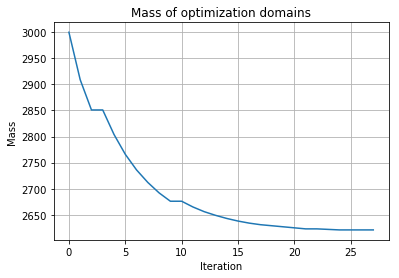

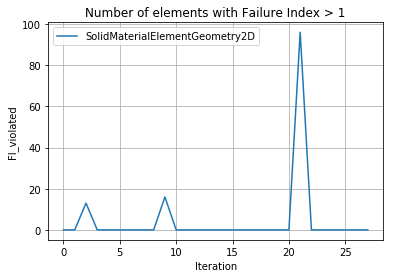

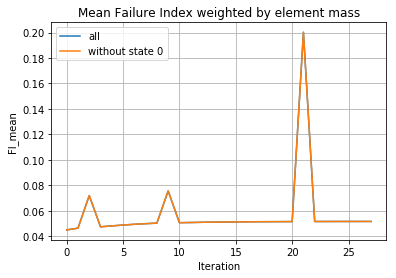

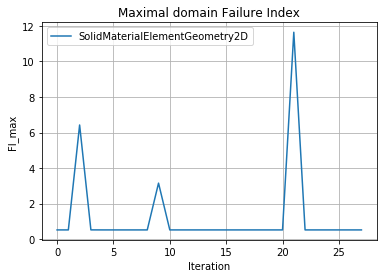

In [242]:
# export the resulting mesh
start_time = time.time()
if "frd" in save_iteration_format:
    beso_lib.export_frd(file_name, nodes, Elements, elm_states, number_of_states)
if "inp" in save_iteration_format:
    beso_lib.export_inp(file_name, nodes, Elements, elm_states, number_of_states)

if reference_points == "nodes":
    os.remove(file_name[:-4] + "_separated.inp")



# plot mass
plt.figure(1)
plt.plot(range(i+1), mass, label="mass")
plt.title("Mass of optimization domains")
plt.xlabel("Iteration")
plt.ylabel("Mass")
plt.grid()
plt.savefig("Mass", dpi=100)

# plot number of elements with FI > 1
plt.figure(2)
dno = 0
for dn in domains_from_config:
    FI_violated_dn = []
    for ii in range(i + 1):
        FI_violated_dn.append(FI_violated[ii][dno])
    plt.plot(range(i + 1), FI_violated_dn, label=dn)
    dno += 1
if len(domains_from_config) > 1:
    FI_violated_total = []
    for ii in range(i + 1):
        FI_violated_total.append(sum(FI_violated[ii]))
    plt.plot(range(i+1), FI_violated_total, label="Total")
plt.legend(loc=2, fontsize=10)
plt.title("Number of elements with Failure Index > 1")
plt.xlabel("Iteration")
plt.ylabel("FI_violated")
plt.grid()
plt.savefig("FI_violated", dpi=100)

# plot mean failure index
plt.figure(3)
plt.plot(range(i+1), FI_mean, label="all")
plt.plot(range(i+1), FI_mean_without_state0, label="without state 0")
plt.title("Mean Failure Index weighted by element mass")
plt.xlabel("Iteration")
plt.ylabel("FI_mean")
plt.legend(loc = 2, fontsize=10)
plt.grid()
plt.savefig("FI_mean", dpi=100)

# plot maximal failure indices
plt.figure(4)
for dn in domains_from_config:
    FI_max_dn = []
    for ii in range(i + 1):
        FI_max_dn.append(FI_max[ii][dn])
    plt.plot(range(i + 1), FI_max_dn, label=dn)
plt.legend(loc=2, fontsize=10)
plt.title("Maximal domain Failure Index")
plt.xlabel("Iteration")
plt.ylabel("FI_max")
plt.grid()
plt.savefig("FI_max", dpi=100)

plt.show()

### 演化的可视化

演化环境由体空间定义为3D空间中的体素,形式为${a_i(x,y,z)}$，其中$a_i( \cdot )=[r,g,b,\alpha]$表示一个向量，表示颜色。

为可视化显示，在PyQtGraph中使用1$\times$4维向量表示颜色，其中第4位表示透明度，0为全透明，1为不透明。

In [2]:
# 以透明体素表达的演化空间

import numpy as np
space_dim = (3,3,3)

# v_data is 3D volume data, each voxel is presented by (r,g,b,a)
v_data =np.empty(space_dim+ (4,), dtype=np.ubyte)
# set all voxels' color to red and nearly total transparent
v_data[:] = [255,0,0,5]   
v_data[0,:,:] = [50,0,0,0]

# For Display
## set the v_data to a GLVolumeItem object then add into a view 
# v = gl.GLVolumeItem(v_data)
# self.view.addItem(v)

In [225]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [226]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

In [227]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [228]:
# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

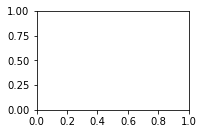

In [51]:
ax = plt.subplot2grid((2, 2), (0, 0))
plt.show()